# **1. Error Analysis Conclusions & work plan**

**1.1 Imports**

In [1]:
# API issue with scikit-learn latest version
# ref : https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

!pip install scikit-learn==1.3.1

In [2]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

**1.2 Loading Data**

In [3]:
dtf = pd.read_csv("./data/CO2 Emissions_Canada.csv")

**1.3 Loading Model**

In [4]:
# Preprocessing
dtf['CO2 Emissions(g/km)'] += np.random.normal(loc=0, scale=30, size=len(dtf))

X = dtf.drop(columns=['CO2 Emissions(g/km)'])
y = dtf['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.drop(columns=['Make'], inplace=True)
X_test.drop(columns=['Make'], inplace=True)
X.drop(columns=['Make'], inplace=True)

transmission_mapping = {
    'A': 'Automatic',
    'AM': 'Automated Manual',
    'AS': 'Automatic with shift',
    'AV': 'Continuously variable',
    'M': 'Manual',
}

def map_transmission(transmission):
    numeric_part = ''.join(filter(str.isdigit, transmission))
    letter_part = ''.join(filter(str.isalpha, transmission))
    if letter_part in transmission_mapping:
        return f"{transmission_mapping[letter_part]}"
    else:
        return transmission

# Apply the mapping to the transmission column
X_train['Transmission'] = X_train['Transmission'].apply(map_transmission)
X_test['Transmission'] = X_test['Transmission'].apply(map_transmission)

# Split categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Define preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Training
baseline_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

# Pipelines
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', baseline_model)
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Model', 'Vehicle Class', 'Transmission'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

**1.4 Previous analysis**

Model Evaluation Metrics:
Mean Absolute Error (MAE): 24.12
Mean Squared Error (MSE): 918.44
Root Mean Squared Error (RMSE): 30.31
R² Score: 0.78
Pearson Correlation: 0.88
Max Error: 111


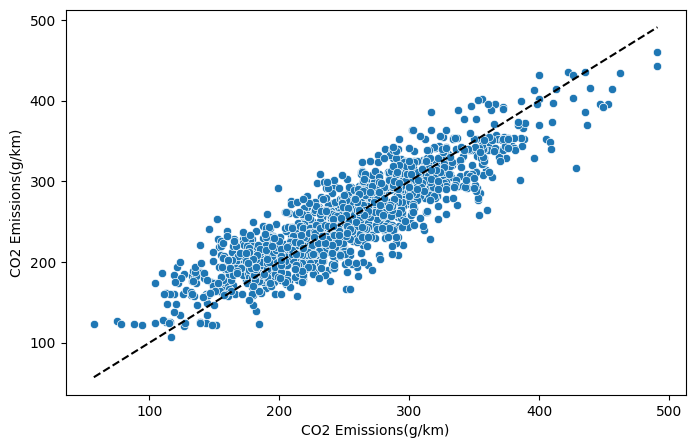

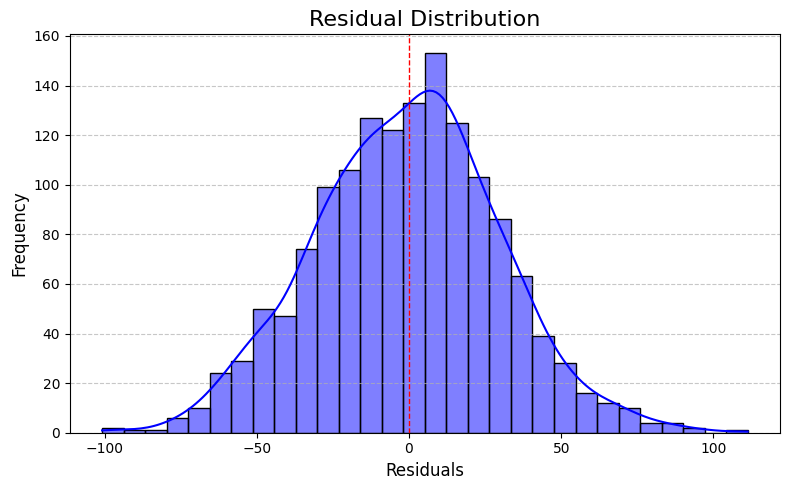

Worst Predictions:
       True Values  Predicted Values   Residuals
2920   428.062848        316.785767  111.277082
4676   353.906818        258.326538   95.580280
4656   359.470725        264.532440   94.938285
2277   253.952134        166.164001   87.788133
4557   315.562592        229.031494   86.531098

Best Predictions:
       True Values  Predicted Values   Residuals
5450   151.894408        252.722946 -100.828538
6022   145.517706        241.391022  -95.873315
3590   198.828634        291.161224  -92.332590
1454   139.242677        221.576920  -82.334242
5177   159.487743        238.933197  -79.445454
Underestimations: 741
Overestimations: 736


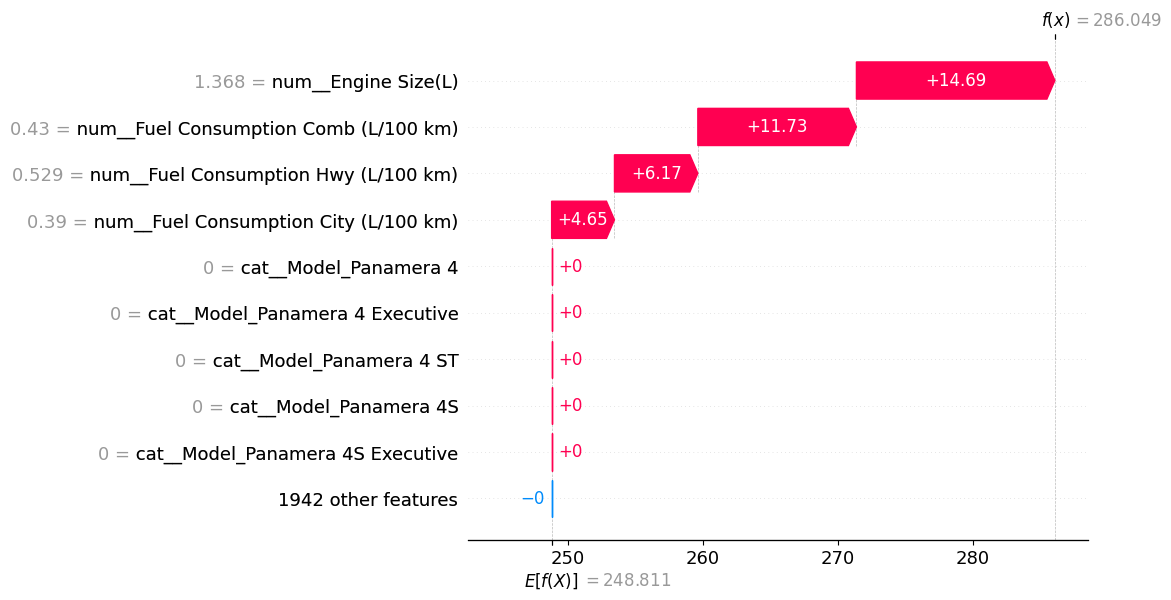

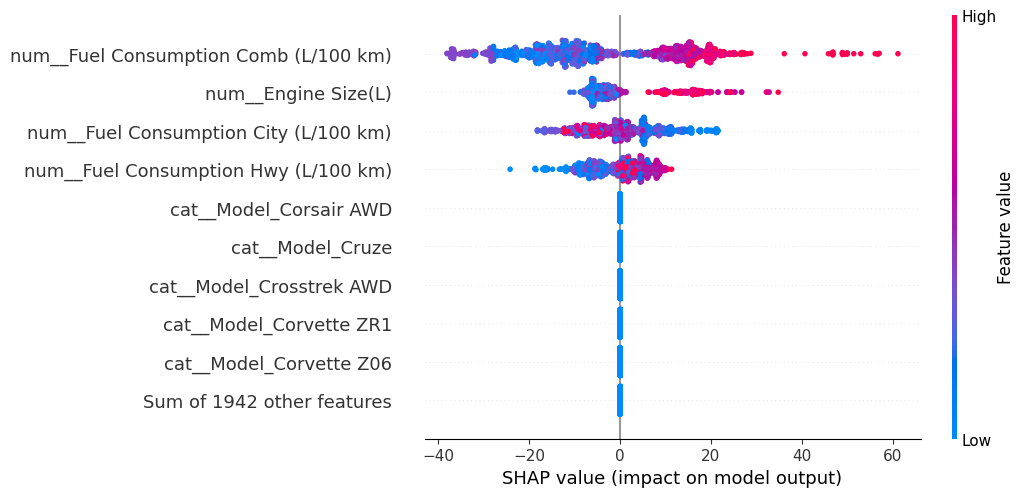

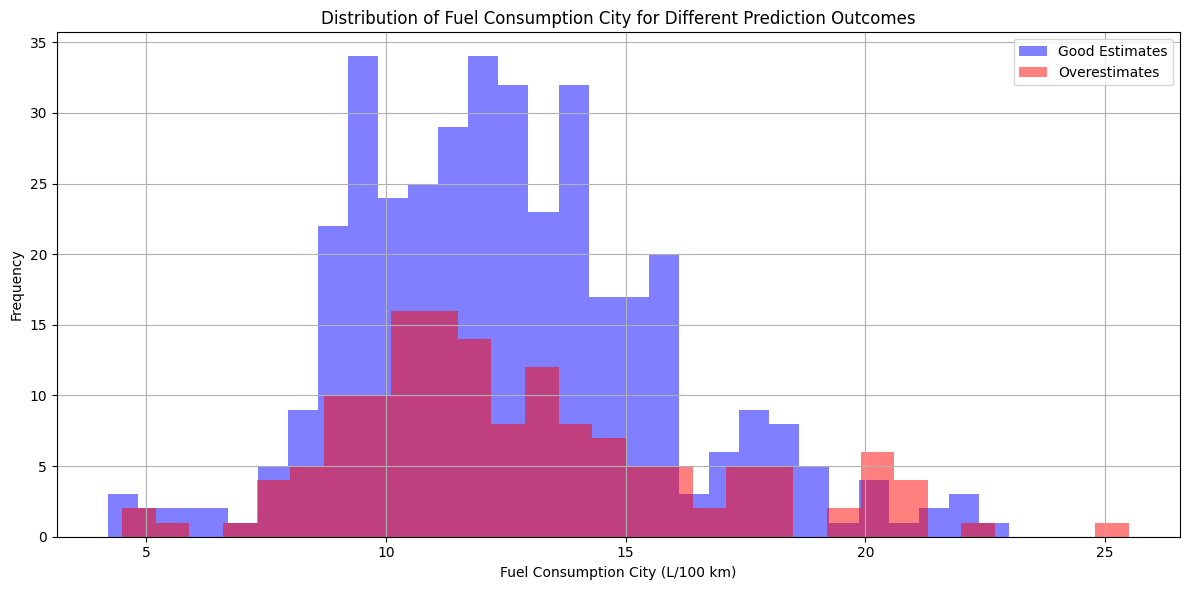

In [5]:
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
pearson, _ = pearsonr(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Pearson Correlation: {pearson:.2f}")

# Residuals
residuals = y_test - y_pred

# Max error
max_error = residuals.abs().max()
tolerance = 1e-6
matching_indices = residuals[abs(residuals.abs() - max_error) < tolerance].index
print("Max Error:", "{:,.0f}".format(max_error))

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, ax=ax)
sns.lineplot(x=y_test, y=y_test, ax=ax, color='black', linestyle='--')

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Residual Distribution", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model performance
error_df = pd.DataFrame({
    "True Values": y_test,
    "Predicted Values": y_pred,
    "Residuals": residuals
})

# Top 5 worst predictions (highest residuals)
worst_predictions = error_df.nlargest(5, "Residuals")
print("Worst Predictions:\n", worst_predictions)

print()

# Top 5 best predictions (lowest residuals)
best_predictions = error_df.nsmallest(5, "Residuals")
print("Best Predictions:\n", best_predictions)

underestimations = residuals[residuals > 0].count()
overestimations = residuals[residuals < 0].count()

print(f"Underestimations: {underestimations}")
print(f"Overestimations: {overestimations}")


# Model explainability

# transform hot one vectors to initial features
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

if hasattr(X_test_transformed, 'toarray'):
    X_test_dense = X_test_transformed.toarray()
else:
    X_test_dense = X_test_transformed

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

X_test_df = pd.DataFrame(X_test_dense, columns=feature_names)

explainer = shap.Explainer(pipeline.named_steps['model'], X_test_df)
shap_values = explainer(X_test_df)

shap.plots.waterfall(shap_values[0])

shap.plots.beeswarm(shap_values)

absolute_residuals = residuals.abs()

over_estimates = X_test.loc[absolute_residuals[absolute_residuals > 50].index]
good_estimates = X_test.loc[absolute_residuals[absolute_residuals < 10].index]

fig, ax = plt.subplots(figsize=(12, 6))

good_estimates['Fuel Consumption City (L/100 km)'].hist(ax=ax, color='blue', alpha=0.5, bins=30, label='Good Estimates')

over_estimates['Fuel Consumption City (L/100 km)'].hist(ax=ax, color='red', alpha=0.5, bins=30, label='Overestimates')

ax.set_xlabel('Fuel Consumption City (L/100 km)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Fuel Consumption City for Different Prediction Outcomes')
ax.legend()

plt.tight_layout()
plt.show()

**1.5 Conclusion from the analysis**

1. **Underestimations:**

  * *Potential Causes:*

    > High-emission vehicles might not be adequately represented in the training dataset.

    > Features that strongly influence high CO2 emissions, such as engine size, transmission type, or specific fuel consumption patterns, might not be fully captured or emphasized by the model.

    > Regularization in the model may bias predictions toward the mean, leading to underestimation of outliers in the higher-emission range.
    
  * *Plan to Address:*

    > Augment the dataset with more samples representing high-emission vehicles.

    > Analyze feature interactions specific to high-emission vehicles to ensure the model captures their influence accurately.

    > Consider fine-tuning the XGBoost hyperparameters like reducing regularization or increasing tree depth to improve sensitivity to extreme values.

2. **Overestimations:**

  * *Potential Causes:*

    > Overfitting to specific features (fuel consumption or engine size) that are disproportionately influential in predicting low emissions.

    > Limited variance in low-emission vehicle data could lead the model to generalize poorly.

    > Misrepresentation of categorical features like transmission type might skew predictions for low-emission vehicles.

  * *Plan to Address:*

    > Examine the preprocessing pipeline for potential bias in one-hot encoding or feature scaling of categorical features like Transmission.

    > Balance the dataset by including more diverse low-emission samples to improve representation.

    > Evaluate feature selection or engineering to reduce noise or overly dominant features for low-emission cases.

3. **Feature Contributions:**

  * The dominant impact of fuel consumption metrics highlights their critical role in predictions, but it also suggests overreliance.

  * *Plan to Address:*

    > Create new features that represent the relationships between existing ones. for example an Efficiency feature that Combine Fuel Consumption Comb (L/100 km) and Engine Size(L).

    > For numerical features like Engine Size or Fuel Consumption, apply Log or Polynomial Transformations to capture nonlinear relationships.

4. **Model Limitations:**

  * The residuals suggest that the XGBoost model is not fully capturing relationships in extreme cases.

  * *Plan to Address:*
    > Experiment with alternative algorithms such as Random Forests or Neural Networks to see if they better handle outliers and extreme cases.

    > Investigate ensemble methods that combine multiple models to balance over- and underestimation tendencies.



**1.6 Work plan**

**Proposed Next Steps:**

  * Perform data augmentation to ensure better representation of both high- and low-emission vehicles.

  * Refine feature engineering to capture additional relevant information.

  * Balacing the data and handling missing data or outliers.

  * Conduct hyperparameter tuning to reduce bias and variance.

  * Evaluate additional machine learning models or ensemble techniques for better performance on extreme cases.

  * Analyze feature importance and interaction further to reduce overfitting or underfitting tendencies.

# **2. Improving Model Performance**

**2.1 imports**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

**2.2 Load data**

In [7]:
dtf = pd.read_csv("./data/CO2 Emissions_Canada.csv")

**2.3 Feature Engineering**

In [8]:
# Creating a new feature: Engine Size Squared
dtf['Engine Size_Squared'] = dtf['Engine Size(L)']**2

# Creating a new feature: Fuel Consumption per Engine Size (to handle potential non-linear relationship)
dtf['Fuel Consumption Comb_per_Engine'] = dtf['Fuel Consumption Comb (L/100 km)'] / (dtf['Engine Size(L)'] + 1e-6)

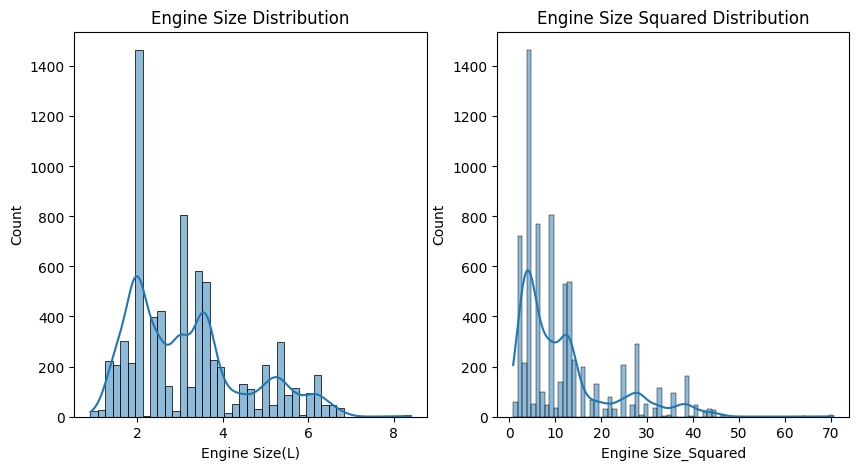

In [9]:
# Visualizing the distribution of Engine Size and the new Engine Size Squared feature
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(dtf['Engine Size(L)'], kde=True)
plt.title('Engine Size Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dtf['Engine Size_Squared'], kde=True)
plt.title('Engine Size Squared Distribution')
plt.show()

**Feature Engineering**

* Created Engine Size_Squared feature to potentially capture non-linear relationships between engine size and emissions.

* Created Fuel Consumption Comb_per_Engine to normalize fuel consumption by engine size. This can be helpful because larger engines generally consume more fuel, but this feature looks at the efficiency of fuel consumption per engine unit.

* In the plots above we visualizes the distribution of Engine Size(L) and the newly created Engine Size_Squared using histograms. This helps to see the effect of the transformation.

**2.4 Feature optimizations**

In [10]:
#Transmission Mapping
transmission_mapping = {
    'A': 'Automatic',
    'AM': 'Automated Manual',
    'AS': 'Automatic with shift',
    'AV': 'Continuously variable',
    'M': 'Manual',
}

def map_transmission(transmission):
    numeric_part = ''.join(filter(str.isdigit, transmission))
    letter_part = ''.join(filter(str.isalpha, transmission))
    if letter_part in transmission_mapping:
        return f"{transmission_mapping[letter_part]}"
    else:
        return transmission

dtf['Transmission'] = dtf['Transmission'].apply(map_transmission)

**Feature optimization**

* Reducing the number of categories to the transmission feature

**2.5 Outlier Handling**

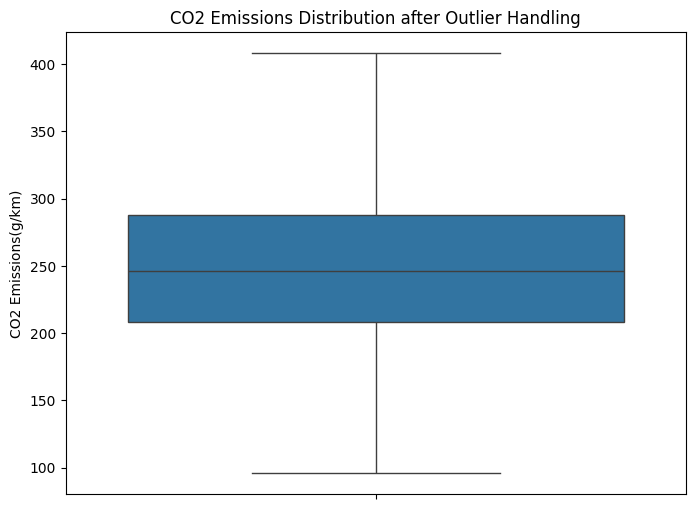

In [11]:
# Outlier Handling (IQR Method)
for col in ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'CO2 Emissions(g/km)']:
    Q1 = dtf[col].quantile(0.25)
    Q3 = dtf[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    dtf[col] = np.clip(dtf[col], lower_bound, upper_bound)

# Visualizing the effect of outlier clipping on CO2 Emissions
plt.figure(figsize=(8, 6))
sns.boxplot(y=dtf['CO2 Emissions(g/km)'])
plt.title('CO2 Emissions Distribution after Outlier Handling')
plt.show()

**Outlier Handling (IQR Method)**

* Clips outliers based on the IQR method. This prevents extreme values from unduly influencing the model.

* In boxplot we visualize the distribution of CO2 Emissions(g/km) after outlier handling. The boxplot shows the median, quartiles, and any remaining outliers (which is less extreme after clipping).

**2.6 Data Splitting**

In [12]:
X = dtf.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y = dtf['CO2 Emissions(g/km)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2.7 Preprocessing Pipelines**

In [13]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

**Preprocessing Pipelines**

* Defines separate preprocessing pipelines for numerical and categorical features.

* Numerical pipeline includes imputation, scaling, and power transformation to handle missing values, standardize data, and address skewness.

* Categorical pipeline uses one-hot encoding.

**2.8 Model Definition & Hyperparameter Tuning**

In [14]:
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgb_model)])

In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 4, 5],
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_iter=10, random_state=42, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

**Model Definition & Hyperparameter Tuning**

* Defines the XGBoost regressor.

* Creates a combined pipeline with preprocessing and the regressor.

* Defined a parameter grid for hyperparameter tuning.

* Used RandomizedSearchCV with cross-validation to find the best hyperparameters. This is more efficient than GridSearchCV for larger search spaces.

# **3. Evaluation and Analyzing the New Model**

**3.1 Evaluating new model**

In [16]:
from scipy.stats import pearsonr
from IPython.display import Markdown, display


y_pred_improved = best_pipeline.predict(X_test)
mae_improved = mean_absolute_error(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)
rmse_improved = np.sqrt(mse_improved)
r2_improved = r2_score(y_test, y_pred_improved)
pearson_improved, _ = pearsonr(y_test, y_pred_improved)

print("\nImproved Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_improved:.2f}")
print(f"Mean Squared Error (MSE): {mse_improved:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_improved:.2f}")
print(f"R² Score: {r2_improved:.2f}")
print(f"Pearson Correlation: {pearson_improved:.2f}")


print("\nBaseline Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Pearson Correlation: {pearson:.2f}")

print()

data = {
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R² Score", "Pearson Correlation"],
    "Baseline Model": [mae, mse, rmse, r2, pearson],
    "Improved Model": [mae_improved, mse_improved, rmse_improved, r2_improved, pearson_improved]
}

# Calculate improvement percentages
improvements = []
for i, metric in enumerate(data["Metric"]):
    baseline_value = data["Baseline Model"][i]
    improved_value = data["Improved Model"][i]

    if metric in ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"]:
        improvement = ((baseline_value - improved_value) / baseline_value) * 100
        improvements.append(f"{improvement:.1f}%")
    elif metric == "R² Score":
        improvement = ((improved_value - baseline_value) / (1-baseline_value)) * 100 # R^2 is calculated differently
        improvements.append(f"{improvement:.1f}%")
    elif metric == "Pearson Correlation":
        improvement = ((improved_value - baseline_value) / (1-baseline_value)) * 100 # Pearson is calculated differently
        improvements.append(f"{improvement:.1f}%")
    else:
        improvements.append("N/A")

data["Improvement (%)"] = improvements

df = pd.DataFrame(data)

markdown_table = df.to_markdown(index=False, numalign='left')

display(Markdown(markdown_table))


Improved Model Evaluation Metrics:
Mean Absolute Error (MAE): 2.19
Mean Squared Error (MSE): 15.43
Root Mean Squared Error (RMSE): 3.93
R² Score: 1.00
Pearson Correlation: 1.00

Baseline Model Evaluation Metrics:
Mean Absolute Error (MAE): 24.12
Mean Squared Error (MSE): 918.44
Root Mean Squared Error (RMSE): 30.31
R² Score: 0.78
Pearson Correlation: 0.88



| Metric                         | Baseline Model   | Improved Model   | Improvement (%)   |
|:-------------------------------|:-----------------|:-----------------|:------------------|
| Mean Absolute Error (MAE)      | 24.117           | 2.19273          | 90.9%             |
| Mean Squared Error (MSE)       | 918.445          | 15.4272          | 98.3%             |
| Root Mean Squared Error (RMSE) | 30.3059          | 3.92775          | 87.0%             |
| R² Score                       | 0.780356         | 0.995406         | 97.9%             |
| Pearson Correlation            | 0.883461         | 0.997707         | 98.0%             |

**Reasons for Improved Performance**

The significant improvements are due to several key changes in the improved model:

* Feature Engineering: Creating Engine Size_Squared and Fuel Consumption Comb_per_Engine likely helped the model capture non-linear relationships and interactions between features and CO2 emissions.

* Outlier Handling: Clipping outliers using the IQR method reduced the influence of extreme values, which can distort model training and lead to worse generalization.

* Missing Value Imputation: Handling missing values ensured that the model could use all available data without being affected by missing entries.

* Power Transformation: Applying a power transformation to numerical features likely reduced skewness and made the data more normally distributed, which can benefit many machine learning models.

* Hyperparameter Tuning with Cross-Validation: Using RandomizedSearchCV with cross-validation allowed for a more effective search for optimal hyperparameters, leading to a better-tuned model.

**3.2 Feature Importance**

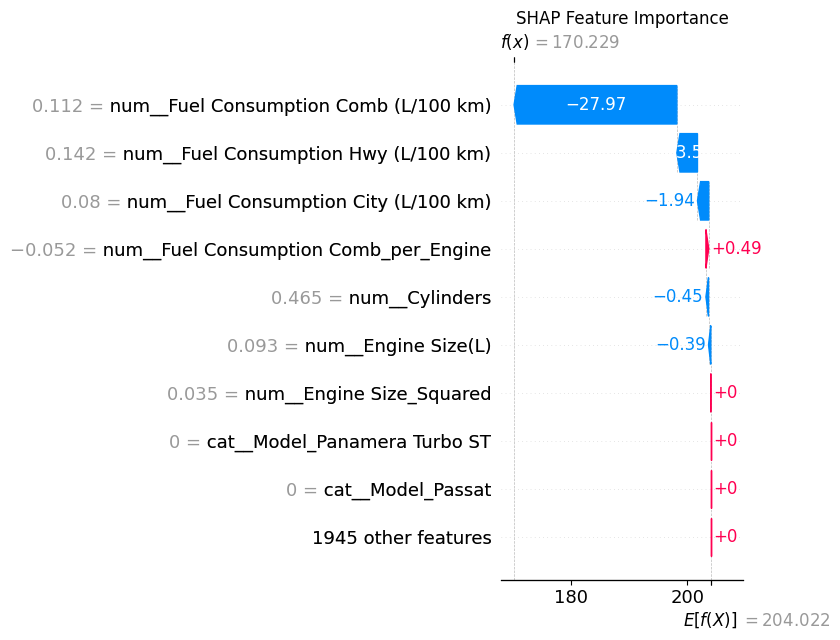

In [17]:
y_pred_improved = best_pipeline.predict(X_test)
residuals_improved = y_test - y_pred_improved

X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
feature_names_transformed = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

if hasattr(X_test_transformed, 'toarray'):
  X_test_dense = X_test_transformed.toarray()
else:
  X_test_dense = X_test_transformed

X_test_df = pd.DataFrame(X_test_dense, columns=feature_names_transformed)

explainer = shap.Explainer(best_pipeline.named_steps['regressor'], X_test_df)
shap_values = explainer(X_test_df)

plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

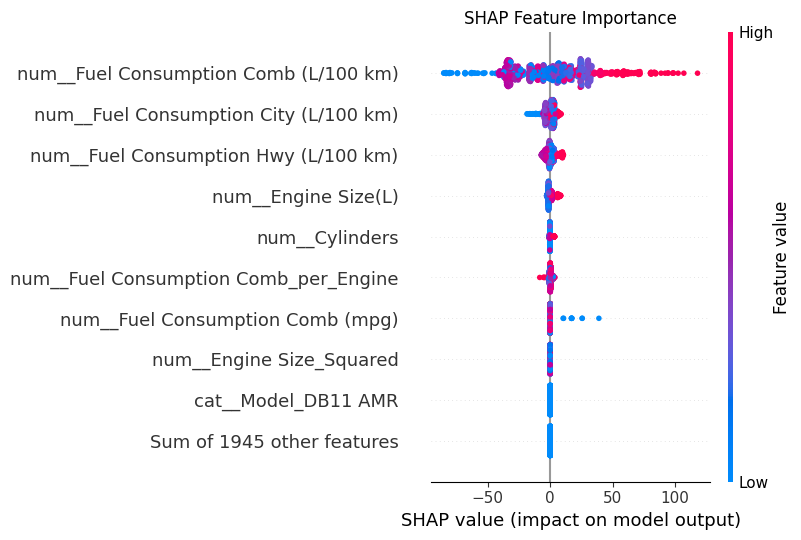

In [18]:
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

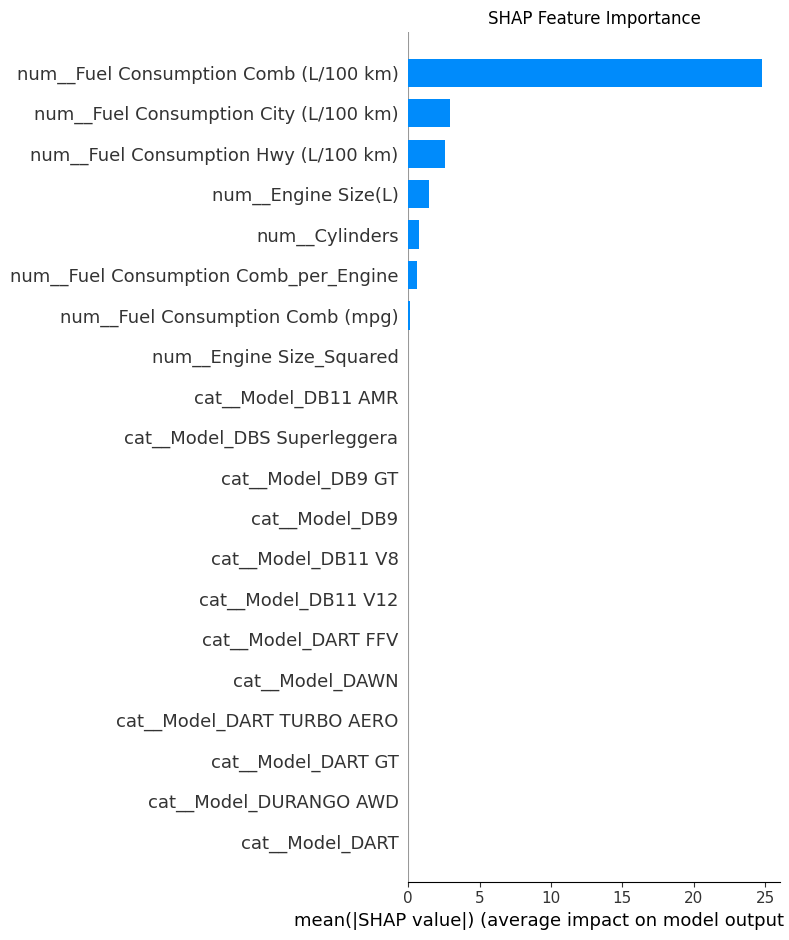

In [19]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

**Observations:**

*   Combined fuel consumption (`num_Fuel Consumption Comb (L/100 km)`) is the strongest predictor. City and highway consumption also matter.

*  Larger engines (`num_Engine Size(L)`) and more cylinders (`num_Cylinders`) increase emissions.

**3.3 Permutation Importance**

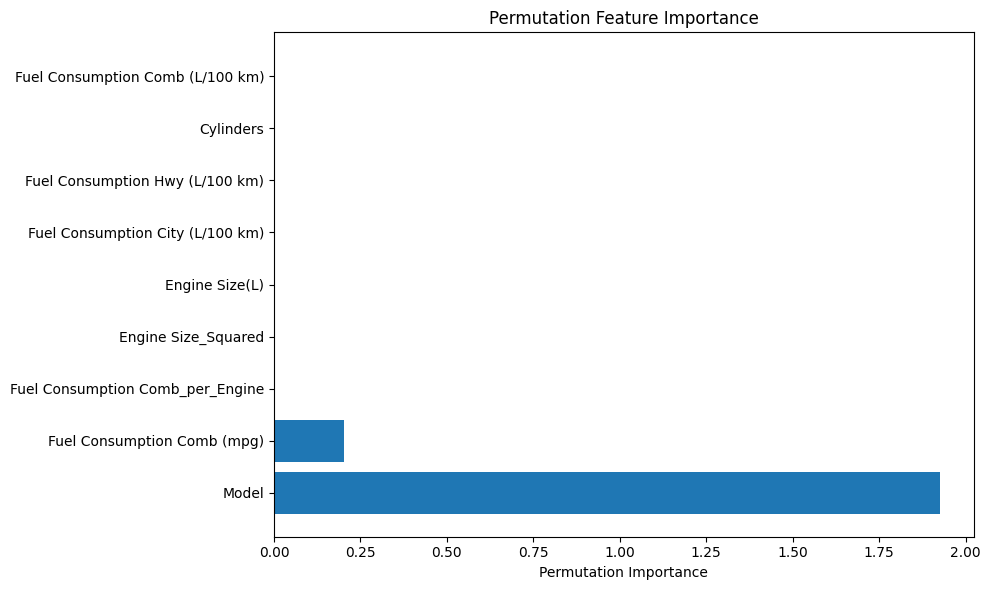

In [20]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = r.importances_mean.argsort()[::-1]

feature_names_original = X.columns
feature_names_encoded = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_mapping = {encoded_name: original_name for original_name in feature_names_original for encoded_name in feature_names_encoded if original_name in encoded_name}
feature_names_sorted = [feature_mapping.get(feature_names_encoded[i], feature_names_encoded[i]) for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names_sorted), r.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

**Observations:**


* The "Model" feauture is the most important feature: The bar corresponding to "Model" is significantly longer than any other bar. This means that shuffling the values of the "Model" feature has the largest negative impact on the model's performance. the model relies most heavily on this feature for making predictions.

* "Fuel Consumption Comb (mpg)" has moderate importance: This feature has the second-longest bar, indicating that it also plays a reasonably important role in the model's predictions, although considerably less so than "Model".

* Other features have low importance: All other features ("Fuel Consumption Comb (L/100 km)", "Cylinders", "Fuel Consumption Hwy (L/100 km)", etc.) have very short bars, close to zero. This means that shuffling their values has little to no impact on the model's performance.

**3.4 Residuals Plot**

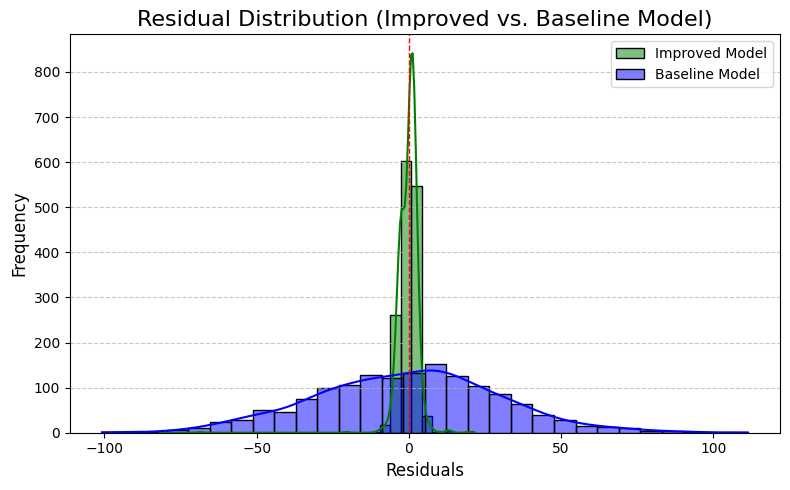

In [21]:
plt.figure(figsize=(8, 5))

sns.histplot(residuals_improved, kde=True, bins=30, color='green', label="Improved Model")

sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.5, label="Baseline Model")

plt.title("Residual Distribution (Improved vs. Baseline Model)", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.axvline(0, color='red', linestyle='--', linewidth=1)

plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

**Observations:**

* Improved Model has significantly smaller errors, the green distribution (Improved Model) is much narrower and more concentrated around zero than the blue distribution (Baseline Model). This is the most important observation. It clearly shows that the improved model's predictions are, on average, much closer to the actual values than the baseline model's predictions. The improved model has significantly reduced the magnitude of the errors.

* The improved model's residuals have a much smaller spread (variance) compared to the baseline model. This means that the improved model's predictions are more consistent and less prone to large errors.

* Both distributions are roughly centered around zero, which is good. This indicates that neither model has a strong systematic bias. However, the improved model achieves this centering with much smaller deviations.

* While neither distribution is perfectly normal, the improved model's distribution is closer to a normal (bell-shaped) distribution than the baseline model's. This is generally desirable, as it suggests that the model's errors are more random.

**3.5 Scatter Plot (Actual vs. Predicted)**

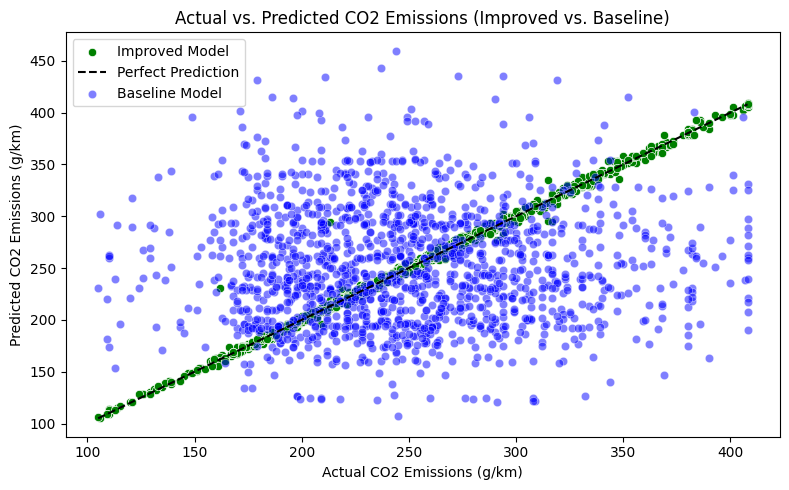

In [22]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=y_test, y=y_pred_improved, color='green', label="Improved Model")
sns.lineplot(x=y_test, y=y_test, color='black', linestyle='--', label="Perfect Prediction")
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.5, label="Baseline Model")

plt.xlabel("Actual CO2 Emissions (g/km)")
plt.ylabel("Predicted CO2 Emissions (g/km)")
plt.title("Actual vs. Predicted CO2 Emissions (Improved vs. Baseline)")

plt.legend()
plt.tight_layout()
plt.show()

**Observations:**

* The green points, representing the improved model's predictions, are clustered very tightly around the black dashed line (the "Perfect Prediction" line). This indicates that the improved model's predictions are very close to the actual values across the entire range of CO2 emissions.

* The blue points, representing the baseline model's predictions, are much more scattered. They deviate significantly from the perfect prediction line, especially at higher CO2 emission values. This shows that the baseline model's predictions have larger errors and are less accurate overall.

* The baseline model tends to under-predict at higher actual CO2 emission values (blue points falling below the black line) and over-predict at lower actual CO2 emission values (blue points falling above the black line). The improved model significantly reduces this tendency, as its predictions are much more consistently close to the actual values.

# **4. Drawing Conclusions About the Data & Creative Applications**

**4.1 Analyzing what the improved model reveals about the data**

**Feature Significance**

> The SHAP values (beeswarm plot) and the permutation importance show that fuel consumption (combined, city, and highway) is by far the most influential factor in predicting CO2 emissions.

> Engine size and number of cylinders also have a significant impact, but to a lesser degree than fuel consumption. The engineered features (fuel consumption per engine size and engine size squared) show some influence, indicating that the model is benefiting from these non-linear transformations.

**Biases or Trends**

> The scatter plot of actual vs. predicted values shows that the baseline model had a tendency to under-predict CO2 emissions at higher actual emission values and over-predict at lower values. The improved model largely corrects this bias, demonstrating a much stronger linear relationship with the actual values. This means the improved model is much better at capturing the full range of CO2 emissions.

**Data Insights**

> The strong influence of fuel consumption is not surprising from a scientific standpoint, as fuel combustion directly produces CO2.
However, the analysis quantifies this relationship and highlights the relative importance of different types of fuel consumption (combined, city, highway). The fact that the engineered features have some influence suggests that there are non-linear relationships between engine size, fuel consumption, and CO2 emissions that the model is capturing.

**4.2 Propose potential applications for the dataset or findings**

**Real-world use cases:**

* Governments could use this model to estimate the impact of fuel efficiency standards or taxes on vehicle emissions.

* Car buyers could use a simplified version of this model to estimate the real-world CO2 emissions of different vehicles, helping them make more environmentally conscious purchasing decisions.

* Companies with vehicle fleets could use the model to optimize their fleet composition for lower emissions.


**Building predictive tools:**

* A CO2 Emission Calculator - A web-based tool where users input vehicle characteristics (engine size, fuel consumption) to get an estimate of CO2 emissions.

* A Vehicle Comparison Tool - A tool that compares the predicted CO2 emissions of different vehicles side-by-side.

*  A predictive maintenance system that may explore if combining emissions data with other sensor data could predict maintenance needs related to emission control systems, reducing emissions over time.